In [126]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from tensorflow.keras import models, layers, callbacks

# Build neural network
def build_model(n_inputs=6, neurons_per_layer=32, n_layers=6):
    model = models.Sequential()
    model.add(layers.Input(shape=(n_inputs,)))
    for _ in range(n_layers):
        model.add(layers.Dense(neurons_per_layer, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train NN on one catalog and predict ALL DR19 stars
def train_and_predict(
    label,
    agedata,
    age_col,
    id_col_catalog,
    id_col_dr19,
    iterations=300,
    patience=50
):
    print("\n===================================================")
    print(f"Training neural network for {label}")
    print("===================================================")


    # MATCH DR19 TO AGE CATALOG
    intersect, ind_dr19, ind_age = np.intersect1d(
        data_masked[id_col_dr19],
        agedata[id_col_catalog],
        return_indices=True
    )
    print(f"{label}: matched stars = {len(intersect)}")


    # BUILD TRAINING SET
    fullx = np.vstack([
        data_masked['teff'][ind_dr19],
        data_masked['logg'][ind_dr19],
        data_masked['m_h_atm'][ind_dr19],
        data_masked['alpha_m_atm'][ind_dr19],
        data_masked['c_h'][ind_dr19],
        data_masked['n_h'][ind_dr19]
    ]).T

    fully = np.array(agedata[age_col])[ind_age].reshape(-1, 1)

    # remove NaNs
    mask_train = np.all(np.isfinite(fullx), axis=1) & np.isfinite(fully[:, 0]) & (fully[:, 0] > 0)
    fullx = fullx[mask_train]
    fully = fully[mask_train]

    print(f"{label}: usable training stars = {len(fullx)}")


    # COMPUTE TRAINING-DOMAIN CUTS
    train_teff  = fullx[:, 0]
    train_logg  = fullx[:, 1]
    train_feh   = fullx[:, 2]
    train_alpha = fullx[:, 3]

    ranges = dict(
        teff_min=np.nanmin(train_teff),
        teff_max=np.nanmax(train_teff),
        logg_min=np.nanmin(train_logg),
        logg_max=np.nanmax(train_logg),
        feh_min=np.nanmin(train_feh),
        feh_max=np.nanmax(train_feh),
        alpha_min=np.nanmin(train_alpha),
        alpha_max=np.nanmax(train_alpha)
    )


    # SCALE TRAINING DATA
    scaling_x = np.median(fullx, axis=0)
    scaling_x[scaling_x == 0] = 1.0

    scaling_y = np.median(fully, axis=0)
    if scaling_y[0] == 0:
        scaling_y[0] = 1.0

    fullx_scaled = fullx / scaling_x
    fully_scaled = fully / scaling_y

    # TRAIN MODEL
    model = build_model()

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True
    )

    model.fit(
        fullx_scaled, fully_scaled,
        epochs=iterations,
        batch_size=256,
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )

 
    # PREDICT AGES FOR ALL DR19
    DR19x = np.vstack([
        data_masked['teff'],
        data_masked['logg'],
        data_masked['m_h_atm'],
        data_masked['alpha_m_atm'],
        data_masked['c_h'],
        data_masked['n_h']
    ]).T

    mask_all = np.all(np.isfinite(DR19x), axis=1)
    DR19x_scaled = np.zeros_like(DR19x)
    DR19x_scaled[mask_all] = DR19x[mask_all] / scaling_x

    preds_scaled = np.full(len(DR19x), np.nan)
    preds_scaled[mask_all] = model.predict(
        DR19x_scaled[mask_all],
        batch_size=2048,
        verbose=0
    ).flatten()

    ages = preds_scaled * scaling_y[0]
    ages = np.clip(ages, 0, 15)

    return ages, ranges



# Load all catalogs
theo_data = Table.read("Theodoridis2025.csv", format="pandas.csv")

p2018 = Table.read("Pinsonneault2018.txt", format="ascii.cds")
p2018['Age'] = 10**(p2018['LogAge'] - 9)

p2025_raw = Table.read("Pinsonneault2025.txt", format="ascii.cds")
ageRC  = np.array(p2025_raw['AgeRC']  * (p2025_raw['EvolState'] == 'RC'))
ageRGB = np.array(p2025_raw['AgeRGB'] * (p2025_raw['EvolState'] == 'RGB'))
ageRC[np.isnan(ageRC)] = 0
ageRGB[np.isnan(ageRGB)] = 0
p2025_raw['Age'] = ageRC + ageRGB
mask25 = p2025_raw['Age'] > 0.1
p2025 = p2025_raw[mask25]

war = Table.read("Warfield2024.txt", format="ascii.cds")

# TRAIN ALL FOUR MODELS
ages_theo,   cut_theo   = train_and_predict("Theodoridis 2025",
    theo_data, "Final_age", "TIC", "tic_v8_id")

ages_p2018,  cut_p2018  = train_and_predict("Pinsonneault 2018",
    p2018, "Age", "2MASS", "sdss4_apogee_id")

ages_p2025,  cut_p2025  = train_and_predict("Pinsonneault 2025",
    p2025, "Age", "GaiaDR3", "gaia_dr3_source_id")

ages_war,    cut_war    = train_and_predict("Warfield 2024 APOK2",
    war, "Age", "APOGEE", "sdss4_apogee_id")

# APPLY TRAINING-DOMAIN CUTS & MAKE 4-PANEL PLOT
def apply_cut(ages, ranges):
    dr_teff  = data_masked['teff']
    dr_logg  = data_masked['logg']
    dr_feh   = data_masked['m_h_atm']
    dr_alpha = data_masked['alpha_m_atm']

    good = (
        (dr_teff  >= ranges['teff_min'])  & (dr_teff  <= ranges['teff_max']) &
        (dr_logg  >= ranges['logg_min'])  & (dr_logg  <= ranges['logg_max']) &
        (dr_feh   >= ranges['feh_min'])   & (dr_feh   <= ranges['feh_max']) &
        (dr_alpha >= ranges['alpha_min']) & (dr_alpha <= ranges['alpha_max']) &
        np.isfinite(ages)
    )
    return good

cutmask_theo  = apply_cut(ages_theo,   cut_theo)
cutmask_p2018 = apply_cut(ages_p2018,  cut_p2018)
cutmask_p2025 = apply_cut(ages_p2025,  cut_p2025)
cutmask_war   = apply_cut(ages_war,    cut_war)


Training neural network for Theodoridis 2025
Theodoridis 2025: matched stars = 17236
Theodoridis 2025: usable training stars = 15883
Epoch 1/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5057 - val_loss: 0.3486
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2862 - val_loss: 0.2232
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2374 - val_loss: 0.2108
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2270 - val_loss: 0.2143
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2242 - val_loss: 0.2184
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2249 - val_loss: 0.2105
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2223 - val_loss: 0.2047
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2236 - val_loss: 0.2074
Epoch 9/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2211 - val_loss: 0.2082
Epoch 10/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2229 - val_loss: 0.2064
Epoch 11/300
50

C:\Users\estro\AppData\Local\Temp\ipykernel_25384\633214591.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])   # reserve space for colorbar


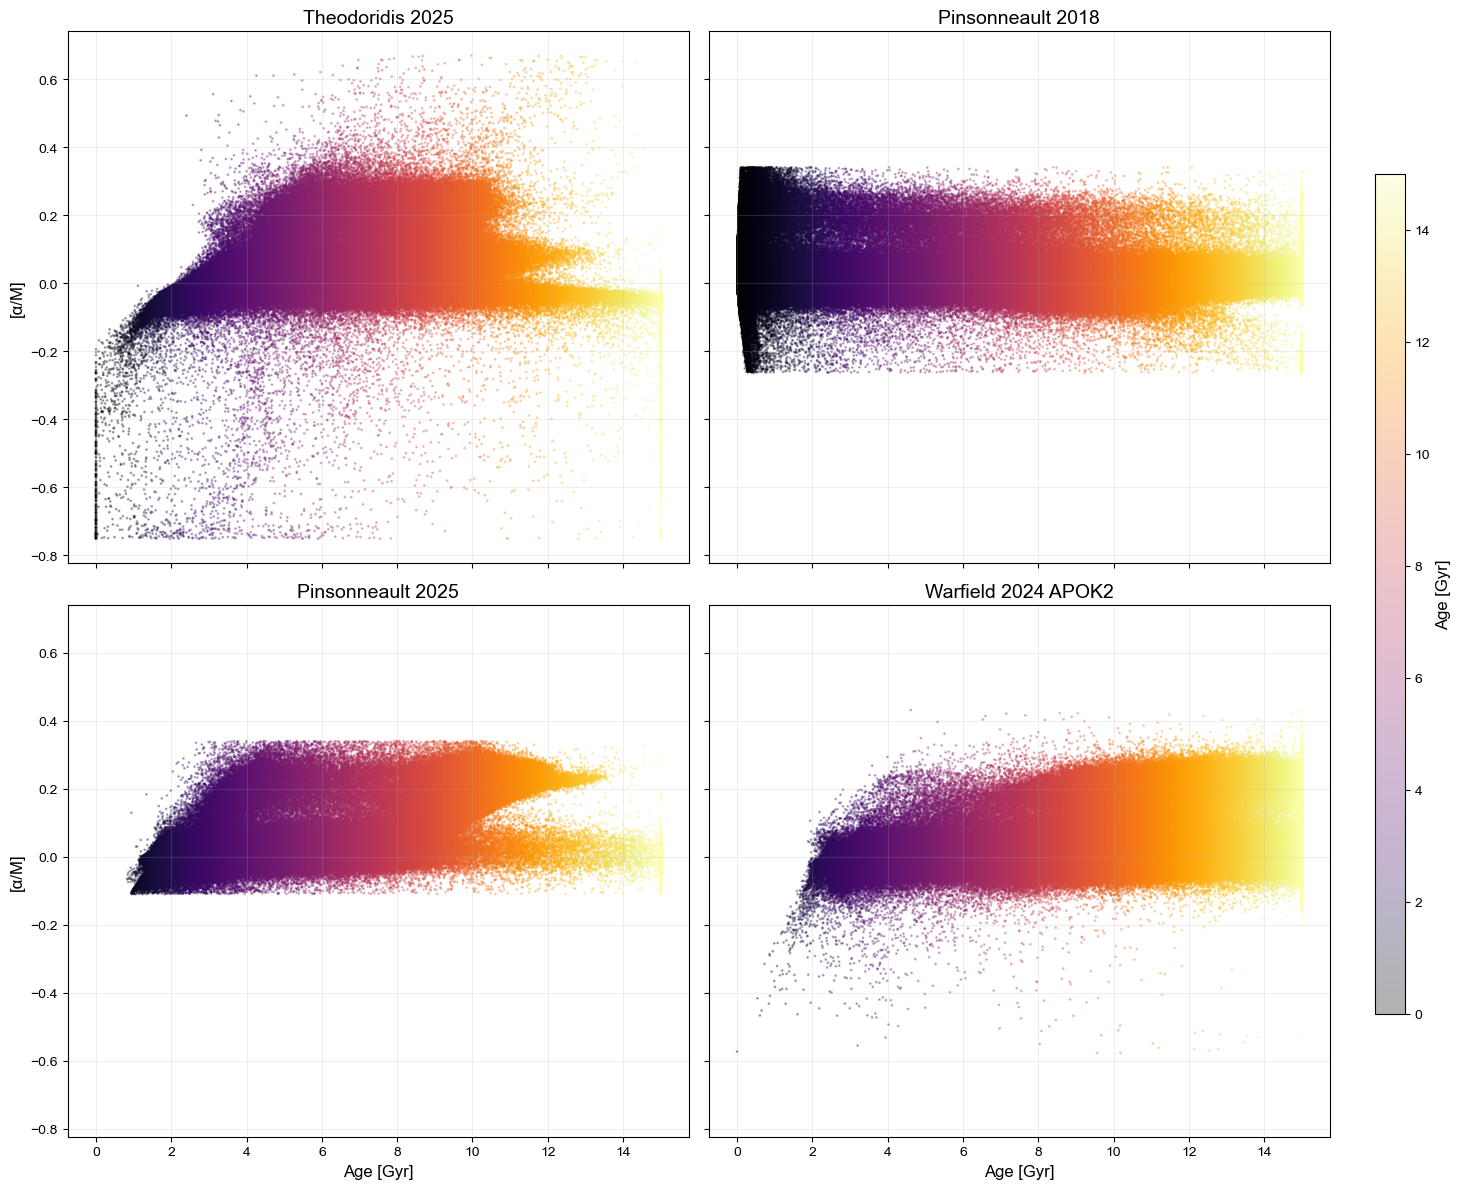

<Figure size 640x480 with 0 Axes>

In [128]:
# PLOT
# sets the default font family for all text elements 
#in Matplotlib plots to a generic "sans-serif" type
plt.rcParams['font.family'] = 'sans-serif' 
#specifies arial as the preferred font for plots
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14  # font size for plot titles
plt.rcParams['axes.labelsize'] = 12  # font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 10 # font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 10 # font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 10 # font size for legend

fig, ax = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = ax.ravel()
titles = ["Theodoridis 2025", "Pinsonneault 2018", "Pinsonneault 2025", "Warfield 2024 APOK2"]
ages_list = [ages_theo, ages_p2018, ages_p2025, ages_war]
masks = [cutmask_theo, cutmask_p2018, cutmask_p2025, cutmask_war]

alpha = data_masked['alpha_m_atm']

for i in range(4):
    m = masks[i]
    sc = axes[i].scatter(
        ages_list[i][m],
        alpha[m],
        s=1, c=ages_list[i][m],
        cmap="inferno", vmin=0, vmax=15, alpha=0.3
    )
    axes[i].set_title(titles[i])
    axes[i].grid(alpha=0.2)

axes[2].set_xlabel("Age [Gyr]")
axes[3].set_xlabel("Age [Gyr]")
axes[0].set_ylabel("[α/M]")
axes[2].set_ylabel("[α/M]")

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label("Age [Gyr]")

plt.tight_layout(rect=[0, 0, 0.90, 1])   # reserve space for colorbar
plt.show()
plt.savefig("alpha_abundance_age.pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)